In [1]:
import json, textwrap
from pathlib import Path

import pandas as pd
import numpy as np

PROMPTS_DIR = Path.home() / 'Desktop' / 'mccviahat' / 'prompts'
DATA_DIR    = Path.home() / 'Desktop' / 'mccviahat' / 'data'
PROMPTS_DIR.mkdir(exist_ok=True)
print(f'Output dir: {PROMPTS_DIR}')

Output dir: /Users/rsalvi/Desktop/mccviahat/prompts


## 1 — Neutral prompts from WikiHow

Load the HuggingFace dataset, keep only English rows where the response
is between 400–500 tokens (estimated as `len(text.split())`), then
format as the expected JSON.

In [2]:
# Load WikiHow dataset from HuggingFace

from datasets import load_dataset
import pandas as pd

ds = load_dataset("0x22almostEvil/multilingual-wikihow-qa-16k", split="train")
df_wiki = ds.to_pandas()

print(len(df_wiki), df_wiki.columns)
df_wiki

/Users/rsalvi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rsalvi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


16822 Index(['INSTRUCTION', 'RESPONSE', 'SOURCE', 'METADATA'], dtype='object')


,INSTRUCTION,RESPONSE,SOURCE,METADATA
0,How to Improve Your Memory Using Meditation,Meditation has been scientifically proven to i...,en.wikihow.com,"{""url"": ""https://www.wikihow.com/Improve-Your-..."
1,How to Clean a Bathroom Fan,One of the most neglected spaces when it comes...,en.wikihow.com,"{""url"": ""https://www.wikihow.com/Clean-a-Bathr..."
2,How to Remove Smell from an Old Leather Bag,"Musty, stinky, odorous old leather bags aren't...",en.wikihow.com,"{""url"": ""https://www.wikihow.com/Remove-Smell-..."
3,How to Set up a Guppy Tank,"Caring for guppies is relatively easy, but it’...",en.wikihow.com,"{""url"": ""https://www.wikihow.com/Set-up-a-Gupp..."
4,How to Fix Chemically Burnt Hair,Many people suffer from hair that is damaged o...,en.wikihow.com,"{""url"": ""https://www.wikihow.com/Fix-Chemicall..."
...,...,...,...,...
16817,Deine Musik auf Spotify bringen,"Hast du eigene Musik, die du auf Spotify hochl...",de.wikihow.com,"{""url"": ""https://de.wikihow.com/Deine-Musik-au..."
16818,LED Streifen anbringen,Wenn du einem Raum Farbe oder Nuancen verleihe...,de.wikihow.com,"{""url"": ""https://de.wikihow.com/LED-Streifen-a..."
16819,Verhindern dass deine Unterwäsche zu sehen ist,Für viele Frauen kann Unterwäsche zu einem wun...,de.wikihow.com,"{""url"": ""https://de.wikihow.com/Verhindern-das..."
16820,In einem Essay zitieren,Um deine These mit konkreten Belegen zu stütze...,de.wikihow.com,"{""url"": ""https://de.wikihow.com/In-einem-Essay..."


In [4]:
import re

def strip_markdown(text: str) -> str:
    """Remove markdown bold, numbered-list prefixes, and flatten to plain prose."""
    text = re.sub(r'\*\*(.+?)\*\*', r'\1', text)              # **bold** → bold
    text = re.sub(r'^\d+\.\s+', '', text, flags=re.MULTILINE) # strip "1. " prefixes
    text = re.sub(r'\n{2,}', '\n', text)                       # collapse blank lines
    text = text.replace('\n', ' ')                              # flatten to single line
    text = re.sub(r' {2,}', ' ', text)                         # collapse multiple spaces
    return text.strip()

# Estimate token count (rough: words × 1.3 for subword tokenisation)
response_col = 'RESPONSE'
title_col = 'INSTRUCTION'

# Filter English
df_wiki = df_wiki[df_wiki["SOURCE"].str.startswith("en.", na=False)]

# Strip markdown formatting from responses
df_wiki[response_col] = df_wiki[response_col].fillna('').apply(strip_markdown)

# Estimate tokens and filter
df_wiki['_est_tokens'] = df_wiki[response_col].apply(lambda x: int(len(str(x).split())))
df_wiki_short = df_wiki[df_wiki['_est_tokens'] < 500].copy()
df_wiki_short = df_wiki_short[df_wiki_short['_est_tokens'] > 400].copy()

print(f'After <500 token filter: {len(df_wiki_short):,} rows')
print(f'Token range: {df_wiki_short["_est_tokens"].min()}–{df_wiki_short["_est_tokens"].max()}')

After <500 token filter: 33 rows
Token range: 405–499


/var/folders/h6/72885xfn72j09dqwjl2d30yw0000gn/T/ipykernel_19748/2912211846.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wiki[response_col] = df_wiki[response_col].fillna('').apply(strip_markdown)
/var/folders/h6/72885xfn72j09dqwjl2d30yw0000gn/T/ipykernel_19748/2912211846.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wiki['_est_tokens'] = df_wiki[response_col].apply(lambda x: int(len(str(x).split())))


In [ ]:
# Build neutral prompts with sequential IDs
SEED = 42

neutral_prompts = []
for idx, (_, row) in enumerate(df_wiki_short.iterrows(), start=1):
    neutral_prompts.append({
        'id': idx,
        'title': str(row[title_col]).strip()[:80],
        'instructions': str(row[response_col]).strip(),
    })

# Preview
for p in neutral_prompts:
    est_tok = int(len(p['instructions'].split()))
    print(f"  [{p['id']}] {p['title'][:60]:60s}  ~{est_tok} tokens  ({len(p['instructions'])} chars)")

  [1] How to Raise a Perfect Garchomp                               ~454 tokens  (2585 chars)
  [2] How to Create Glow in the Dark Log Campfire Stools            ~437 tokens  (2462 chars)
  [3] How to Eat Honeycomb                                          ~490 tokens  (2799 chars)
  [4] How to Make Your Own Skin in Minecraft                        ~475 tokens  (2638 chars)
  [5] How to Learn a Piano Piece Quickly                            ~453 tokens  (2434 chars)
  [6] How to Make Medical Marijuana Brownies                        ~413 tokens  (2233 chars)
  [7] How to Make Waterproof Matches                                ~461 tokens  (2448 chars)
  [8] How to Write a Speech if You're Third Speaker                 ~452 tokens  (2665 chars)
  [9] How to Create a Hot Compress for Acne Treatment and Skin Hea  ~467 tokens  (2537 chars)
  [10] How to Clean Tennis Balls                                     ~455 tokens  (2385 chars)
  [11] How to Make Coca Cola Icees at Home                 

In [6]:
# Save neutral prompts
neutral_path = PROMPTS_DIR / 'neutral_wikihow.json'
neutral_path.write_text(json.dumps(neutral_prompts, indent=2, ensure_ascii=False), encoding='utf-8')
print(f'Saved {len(neutral_prompts)} neutral prompts → {neutral_path}')

Saved 33 neutral prompts → /Users/rsalvi/Desktop/mccviahat/prompts/neutral_wikihow.json


## 2 — Emotional prompts from Creepypasta

Load the Excel file, filter to stories with 400–500 tokens and
rating between 7–9, then format.

In [7]:
# Load creepypasta dataset
xlsx_path = DATA_DIR / 'creepypastas.xlsx'
assert xlsx_path.exists(), f'Missing: {xlsx_path}'

df_creepy = pd.read_excel(xlsx_path)
print(f'Raw creepypasta rows: {len(df_creepy):,}')
print(f'Columns: {list(df_creepy.columns)}')
df_creepy.head(3)

Raw creepypasta rows: 3,510
Columns: ['story_name', 'average_rating', 'tags', 'body', 'estimated_reading_time', 'publish_date', 'categories']


,story_name,average_rating,tags,body,estimated_reading_time,publish_date,categories
0,"If You’re Armed and at the Glenmont Metro, Ple...",9.25,"drug trials, drugs, experimentation, experime...","If you’re armed and at the Glenmont metro, ple...",12 minutes,"February 20, 2020","Drugs and Addictions, Madness, Paranoia, and ..."
1,A Shattered Life,9.13,"disease, entities, Matt Dymerski, monsters, p...","I don’t know when you’re going to read this,...",14 minutes,"July 22, 2020","Madness, Paranoia, and Mental Illness, Monste..."
2,My Father Punished Me When I Talked to Ghosts,9.12,"abductions, blindness, child abuse, childhood...","I’ve been blind since birth. As I grew up, eve...",8 minutes,"December 10, 2019","Abductions and Kidnappings, Children and Chil..."


In [ ]:
import pandas as pd

# extract number from "12 minutes"
df_creepy["reading_minutes"] = (
    df_creepy["estimated_reading_time"]
      .str.extract(r"(\d+)")
      .astype(float)
)

# token count in body
df_creepy["token_count"] = df_creepy["body"].str.split().str.len()

# keep between 400 and 500 tokens, rating 7–9
df_creepy_short = df_creepy[df_creepy["token_count"].between(400, 500)]
df_creepy_short = df_creepy_short[df_creepy_short["average_rating"].between(7, 9)]

print(f'{len(df_creepy_short)} stories after filtering')
df_creepy_short.head()

50


,story_name,average_rating,tags,body,estimated_reading_time,publish_date,categories,reading_minutes,token_count
202,Stairs,8.96,NaN,"In 1984, there lived an old widowed lady by h...",2 minutes,"October 30, 2012","Deaths, Murders, and Disappearances, Strange ...",2.0,484
404,The Kaleidoscope,8.78,NaN,"While honeymooning in Maine, my wife and I sto...",2 minutes,"October 13, 2008",Artifacts and Objects\nPlease wait...\n,2.0,401
414,I Told You To Smile,8.77,NaN,"It was the 2nd of January, 2:04 AM. I woke up ...",2 minutes,"December 3, 2012",Strange and Unexplained\n,2.0,474
590,Tower of Silence,8.64,NaN,"January 19, 2003 —\nIndian officials ventured ...",2 minutes,"June 18, 2012","Deaths, Murders, and Disappearances, Location...",2.0,414
698,The Boogey Man,8.56,Vincent Vena Cava\n,It started with my 3 year old son screaming in...,2 minutes,"October 29, 2013",Strange and Unexplained,2.0,459


In [ ]:
# Build emotional prompts with sequential IDs
creepy_title_col = 'story_name'
creepy_body_col = 'body'
emotional_prompts = []
for idx, (_, row) in enumerate(df_creepy_short.iterrows(), start=1):
    emotional_prompts.append({
        'id': idx,
        'title': str(row[creepy_title_col]).strip()[:80],
        'instructions': str(row[creepy_body_col]).strip(),
    })

In [13]:
# Save emotional prompts
emotional_path = PROMPTS_DIR / 'emotional_creepypasta.json'
emotional_path.write_text(json.dumps(emotional_prompts, indent=2, ensure_ascii=False), encoding='utf-8')
print(f'Saved {len(emotional_prompts)} emotional prompts → {emotional_path}')

Saved 50 emotional prompts → /Users/rsalvi/Desktop/mccviahat/prompts/emotional_creepypasta.json


## 3 — Summary & Token-Count Comparison

Side-by-side comparison to check that the two sets are roughly matched
in length — important for reducing confounders in the HAT experiment.

                         Neutral (WikiHow)   Emotional (Creepypasta)
----------------------------------------------------------------------
Mean tokens                            589                       586
Std tokens                              34                        39
Min tokens                             526                       520
Max tokens                             648                       650


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (33,).

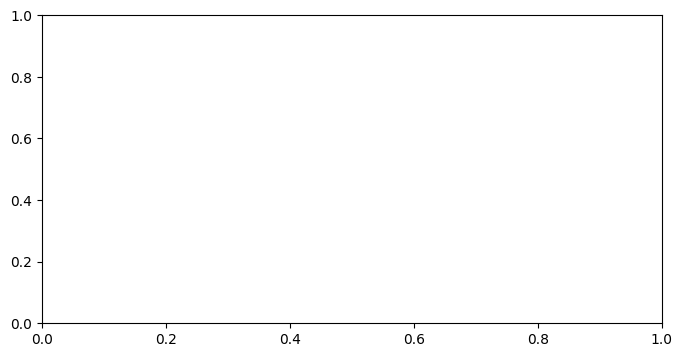

In [ ]:
import matplotlib.pyplot as plt

n_toks = [int(len(p['instructions'].split()) * 1.3) for p in neutral_prompts]
e_toks = [int(len(p['instructions'].split()) * 1.3) for p in emotional_prompts]

n_prompts = max(len(n_toks), len(e_toks))

print(f'{"":20s}  {"Neutral (WikiHow)":>20s}  {"Emotional (Creepypasta)":>24s}')
print('-' * 70)
print(f'{"Count":20s}  {len(n_toks):20d}  {len(e_toks):24d}')
print(f'{"Mean tokens":20s}  {np.mean(n_toks):20.0f}  {np.mean(e_toks):24.0f}')
print(f'{"Std tokens":20s}  {np.std(n_toks):20.0f}  {np.std(e_toks):24.0f}')
print(f'{"Min tokens":20s}  {np.min(n_toks):20d}  {np.min(e_toks):24d}')
print(f'{"Max tokens":20s}  {np.max(n_toks):20d}  {np.max(e_toks):24d}')

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(n_prompts)
w = 0.35
ax.bar(x - w/2, n_toks[:n_prompts], w, label='Neutral (WikiHow)', color='steelblue', alpha=0.8)
ax.bar(x + w/2, e_toks[:n_prompts], w, label='Emotional (Creepypasta)', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(n_prompts)], fontsize=7)
ax.set_xlabel('Prompt ID')
ax.set_ylabel('Estimated tokens')
ax.set_title('Token Count Comparison: Neutral vs Emotional')
ax.legend()
plt.tight_layout()
plt.show()

ratio = np.mean(e_toks) / np.mean(n_toks)
print(f'\nMean ratio (emotional/neutral): {ratio:.2f}')
if 0.8 <= ratio <= 1.2:
    print('✓ Conditions are well-matched in token count')
else:
    print(f'⚠ Token counts differ by {abs(ratio-1)*100:.0f}% — consider re-sampling or trimming')

## Output files

| File | Description |
|------|-------------|
| `prompts/neutral_wikihow.json` | 20 WikiHow how-to instructions (<500 tokens each) |
| `prompts/emotional_creepypasta.json` | 20 creepypasta stories (<5 min reading time) |

Usage:
```bash
python3 scripts/run_prompts_json.py --json prompts/neutral_wikihow.json --label neutral
python3 scripts/run_prompts_json.py --json prompts/emotional_creepypasta.json --label emotional
```